In [1]:
import numpy as np
import tifffile
import glob
import os

from reco_helper import reconstruct_one_slice, get_spectrum

from matplotlib import pyplot as plt
%matplotlib inline

from tqdm.auto import tqdm

from skimage.metrics import structural_similarity as ssim 

In [2]:
after = tifffile.imread('/mnt/HD-LSDF/sd18a004/for_yaroslav/neutron_data/n2n_results/processed_first/0.tif')
before = np.load('/mnt/HD-LSDF/sd18a004/for_yaroslav/neutron_data/preprocessed_projections/projections_339/proj_0.npy')
after_slice = tifffile.imread('/mnt/HD-LSDF/sd18a004/for_yaroslav/neutron_data/n2n_results/processed_after_reconstruction/127.tif')[:, 12:-12, 12:-12]

In [3]:
before.shape, after.shape

((339, 512, 512), (339, 512, 512))

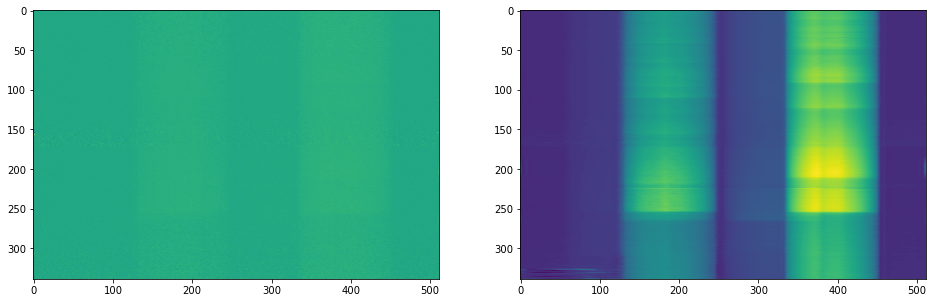

In [4]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 10))
ax1.imshow(before[:, 200])
ax2.imshow(after[:, 200])
plt.show()

In [5]:
slice_number = 127

sino_before = []
for i in tqdm(range(120)):
    sino_before.append(np.load(f'/mnt/HD-LSDF/sd18a004/for_yaroslav/neutron_data/preprocessed_projections/projections_339/proj_{i}.npy', 
                               mmap_mode='r')[:, slice_number])
sino_before = np.stack(sino_before, axis=1)

reco_before = reconstruct_one_slice(sino_before, n_channels=339)[:, 12:-12, 12:-12]

  0%|          | 0/120 [00:00<?, ?it/s]

reconstructing channels:   0%|          | 0/339 [00:00<?, ?it/s]

In [6]:
sino_after = []
for i in tqdm(range(120)):
    img = tifffile.memmap(f'/mnt/HD-LSDF/sd18a004/for_yaroslav/neutron_data/n2n_results/processed_first/{i}.tif')
    sino_after.append(img[:, slice_number])
sino_after = np.stack(sino_after, axis=1)
reco_after = reconstruct_one_slice(sino_after, n_channels=339)[:, 12:-12, 12:-12]

  0%|          | 0/120 [00:00<?, ?it/s]

reconstructing channels:   0%|          | 0/339 [00:00<?, ?it/s]

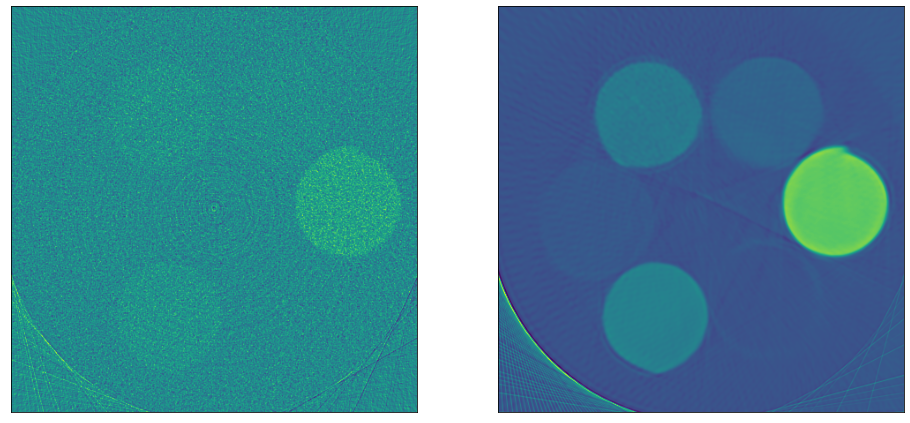

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 10))
ax1.imshow(reco_before[200])
ax1.set_xticks([])
ax1.set_yticks([])
ax2.imshow(reco_after[200])
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()

In [8]:
tvtgvd = np.load(f'/mnt/HD-LSDF/sd18a004/for_yaroslav/neutron_data/pdhg_tv_tgv_alpha_0.0075_beta_0.3.npy')

In [9]:
binning=[16, 8, 8, 4]
# parse specral info
# shutter values
tof_lim_left = np.array([15e-3, 27e-3, 44e-3, 53e-3])
tof_lim_right = np.array([26.68e-3, 43.68e-3, 52.68e-3, 72e-3])
tof_bin_width = np.array([10.24, 20.48, 20.48, 40.96])

# number of shutter intervals
n_intervals = 4

# binning in each shutter interval
binning = np.array(binning)

# calculate number of bins in each shutter interval
# TOF is in seconds, bins in microseconds
n_bins = np.int_(np.floor((tof_lim_right - tof_lim_left) / (tof_bin_width * binning * 1e-6)))
n_bins_total = np.sum(n_bins)

## prepare spectral axis for plots
tof_bins_left = np.zeros((n_bins_total), dtype = np.float32)
tof_bins_right = np.zeros((n_bins_total), dtype = np.float32)
counter = 0
for i in range(n_intervals):
    tof_bins_left[counter:(counter+n_bins[i])] = np.arange(tof_lim_left[i], tof_lim_right[i]-tof_bin_width[i]*binning[i]*1e-6, tof_bin_width[i]*binning[i]*1e-6, dtype = np.float32)
    tof_bins_right[counter:(counter+n_bins[i])] = tof_bins_left[counter:(counter+n_bins[i])] + (tof_bin_width[i]*binning[i]*1e-6)
    counter = counter+n_bins[i]

tof_bins_center = ((tof_bins_left + tof_bins_right) / 2)

l = 56.428
# full equation
# angstrom_lim_1 = (tof_lim_1 * const.h) / (const.m_n * l) * 1e10
# angstrom_lim_2 = (tof_lim_2 * const.h) / (const.m_n * l) * 1e10
# and it's simplified form
angstrom_lim_1 = (tof_lim_left * 3957) / l
angstrom_lim_2 = (tof_lim_right * 3957) / l
angstrom_bins_center = (tof_bins_center * 3957) / l
angstrom_bin_width = (tof_bin_width * 1e-6 * 3957) / l

In [10]:
import csv
import sklearn.metrics
from matplotlib import pyplot as plt

def prepare_spectrum_points(reconstructed_slice=None, binning=[16, 8, 8, 4]):

    # parse specral info
    # shutter values
    tof_lim_left = np.array([15e-3, 27e-3, 44e-3, 53e-3])
    tof_lim_right = np.array([26.68e-3, 43.68e-3, 52.68e-3, 72e-3])
    tof_bin_width = np.array([10.24, 20.48, 20.48, 40.96])

    # number of shutter intervals
    n_intervals = 4

    # binning in each shutter interval
    binning = np.array(binning)

    # calculate number of bins in each shutter interval
    # TOF is in seconds, bins in microseconds
    n_bins = np.int_(np.floor((tof_lim_right - tof_lim_left) / (tof_bin_width * binning * 1e-6)))
    n_bins_total = np.sum(n_bins)

    ## prepare spectral axis for plots
    tof_bins_left = np.zeros((n_bins_total), dtype = np.float32)
    tof_bins_right = np.zeros((n_bins_total), dtype = np.float32)
    counter = 0
    for i in range(n_intervals):
        tof_bins_left[counter:(counter+n_bins[i])] = np.arange(tof_lim_left[i], tof_lim_right[i]-tof_bin_width[i]*binning[i]*1e-6, tof_bin_width[i]*binning[i]*1e-6, dtype = np.float32)
        tof_bins_right[counter:(counter+n_bins[i])] = tof_bins_left[counter:(counter+n_bins[i])] + (tof_bin_width[i]*binning[i]*1e-6)
        counter = counter+n_bins[i]

    tof_bins_center = ((tof_bins_left + tof_bins_right) / 2)

    l = 56.428
    # full equation
    # angstrom_lim_1 = (tof_lim_1 * const.h) / (const.m_n * l) * 1e10
    # angstrom_lim_2 = (tof_lim_2 * const.h) / (const.m_n * l) * 1e10
    # and it's simplified form
    angstrom_lim_1 = (tof_lim_left * 3957) / l
    angstrom_lim_2 = (tof_lim_right * 3957) / l
    angstrom_bins_center = (tof_bins_center * 3957) / l
    angstrom_bin_width = (tof_bin_width * 1e-6 * 3957) / l

    # import table data with attenuation values for different wavelength
    attenuation_zn = np.zeros((3974, 2), dtype=np.float32)
    with open('Zn_new.txt', 'r') as attenuation_values_csv:
        csv_reader = csv.reader(attenuation_values_csv, delimiter = '\t')
        
        # skip first row with column names
        next(csv_reader)
        counter = 0
        for row in csv_reader:
            
            attenuation_zn[counter, :] = row
            counter += 1

    attenuation = np.zeros((5998, 11), dtype = np.float32)
    with open('attenuation.txt', 'r') as attenuation_values_csv:
        csv_reader = csv.reader(attenuation_values_csv, delimiter = '\t')
        
        # skip first row with column names
        next(csv_reader)
        counter = 0
        for row in csv_reader:
            attenuation[counter, :] = row
            counter += 1

    # wavelength - first column
    wavelength = np.sort(np.copy(attenuation_zn[:, 0]))

    attenuation_zn = attenuation_zn[:, 1]
    # interpolate attenuation on common axis
    attenuation_tmp = np.interp(angstrom_bins_center, wavelength, attenuation_zn)
    attenuation_zn = np.copy(attenuation_tmp)
    attenuation_zn[-1] = attenuation_zn[-2]

    # wavelength - first column
    wavelength = np.copy(attenuation[:, 0])
    attenuation[:, :-1] = attenuation[:, 1:]
    # add a column with attenuation for air - currently zero
    attenuation[:, -1] = 0
    # column names
    materials = np.array(["Ti", "Fe", "Ni", "Cu", "Cd", "W", "Pb", "Al", "Zn", "ZnO", "Air"])

    # interpolate attenuation on common axis
    attenuation_tmp = np.zeros((n_bins_total,11), dtype = np.float32)

    for i in range(11):
        attenuation_tmp[:,i] = np.interp(angstrom_bins_center, wavelength, attenuation[:,i])

    attenuation = attenuation_tmp
    attenuation[:, 8] = attenuation_zn

    # set-up plots
    sample_materials = np.array(["Fe", "Ni", "Cu",  "Zn", "Al"])

    #green, orange, blue, black, terracota
    colors = [[44/255, 162/255, 95/255],\
              [227/255, 74/255, 51/255],\
              [44/255, 127/255, 184/255],\
              [99/255, 99/255, 99/255],\
              [191/255, 91/255, 23/255]]

    # this coefficients scale gray values 
    # the reason why we need to do this is because 
    # we used not solid materails but powders
    # i.e. each reconstucted voxel contains a mixture of
    # air and maetrial
    coeff = [0.65, 0.9, 0.55, 1, 0.9]

    # roi coordinates and size which we used to generate
    # spectral profiles
    # roi_row = np.array([362, 242, 120, 132, 252])
    # roi_col = np.array([182, 382, 150, 312, 100])

    roi_row = np.array([362, 242, 120, 132, 252])
    roi_col = np.array([182, 382, 150, 312, 100])

    roi_pix_v = 1
    roi_pix_h = 1

    nrows = 5
    ncols = 2
    
        
    if reconstructed_slice is not None:
        #%% plot results - spectral comparison
        # now it compares FBP vs FBP :) in your case I guess it will be FBP vs denoised FBP
        # scale pixel values
        FBP_recon = reconstructed_slice / 0.055
    
        predicted_lines = []
        for i in range(5):
            predicted_lines.append(1/coeff[i]*np.mean(np.mean(FBP_recon[:, roi_row[i]:(roi_row[i]+roi_pix_v), roi_col[i]:(roi_col[i]+roi_pix_h)], axis = 2), axis = 1))

    else:
        predicted_lines = []
        for i in range(5):
            predicted_lines.append(attenuation[:, materials == sample_materials[i]])
    
    return predicted_lines

In [11]:
th = prepare_spectrum_points()

In [12]:
raw = prepare_spectrum_points(reconstructed_slice=reco_before)

In [13]:
nnp = prepare_spectrum_points(reconstructed_slice=reco_after)

In [14]:
nns = prepare_spectrum_points(reconstructed_slice=after_slice)

In [15]:
tv = prepare_spectrum_points(reconstructed_slice=tvtgvd)

In [16]:
materials = np.array(["Fe", "Ni", "Cu",  "Zn", "Al"])

In [17]:
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FormatStrFormatter
from matplotlib import ticker

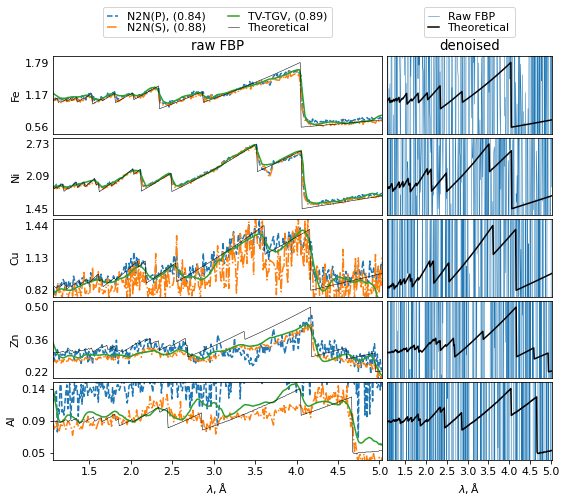

In [41]:
plt.rcParams.update({'font.size': 11})

fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(8, 7), sharex=True, gridspec_kw={'width_ratios': [2, 1]})

for i in range(5):
    cax = axes[i][0]
    cax.plot(angstrom_bins_center, nnp[i], ls='--',label=f'N2N(P), ({ssim(nnp[i], th[i].squeeze()):.2f})')
    cax.plot(angstrom_bins_center, nns[i], ls='-.', label=f'N2N(S), ({ssim(nns[i], th[i].squeeze()):.2f})')
    cax.plot(angstrom_bins_center, tv[i],  ls='-', label=f'TV-TGV, ({ssim(tv[i], th[i].squeeze()):.2f})')
    cax.plot(angstrom_bins_center, th[i], c='k', lw=0.5, label='Theoretical')
    
    cax.set_ylim(th[i].min()-0.1*(th[i].max() - th[i].min()), th[i].max()+0.1*(th[i].max() - th[i].min()))
    cax.set_xlim(angstrom_bins_center.min(), angstrom_bins_center.max())
    cax.set_ylabel(materials[i])
    cax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    cax.set_yticks([th[i].min(), th[i].max(), (th[i].min()+th[i].max())/2])
    
    
for i in range(5):
    cax = axes[i][1]
    cax.plot(angstrom_bins_center, raw[i], lw=0.5, label='Raw FBP')
    cax.plot(angstrom_bins_center, th[i], c='k', label='Theoretical')
    
    cax.set_ylim(th[i].min()-0.1*(th[i].max() - th[i].min()), th[i].max()+0.1*(th[i].max() - th[i].min()))
    cax.set_xlim(angstrom_bins_center.min(), angstrom_bins_center.max())
    cax.set_yticks([])

for i in range(4):
    axes[i][0].tick_params(length=0)
    axes[i][1].tick_params(length=0)

axes[0][0].set_title('raw FBP')
axes[0][1].set_title('denoised')
axes[0][1].legend(loc=9, ncol=1, bbox_to_anchor=(0.5, 1.7), handlelength=1, labelspacing=0.1)
axes[0][0].legend(loc=9, ncol=2, bbox_to_anchor=(0.5, 1.7), handlelength=1, labelspacing=0.1)
axes[-1][0].set_xlabel(r'$\lambda, \mathrm{\AA}$')
axes[-1][1].set_xlabel(r'$\lambda, \mathrm{\AA}$')
plt.tight_layout()
plt.subplots_adjust(hspace=.05, wspace=.02)


plt.savefig('figures/neutron_profiles.pdf')
plt.show()

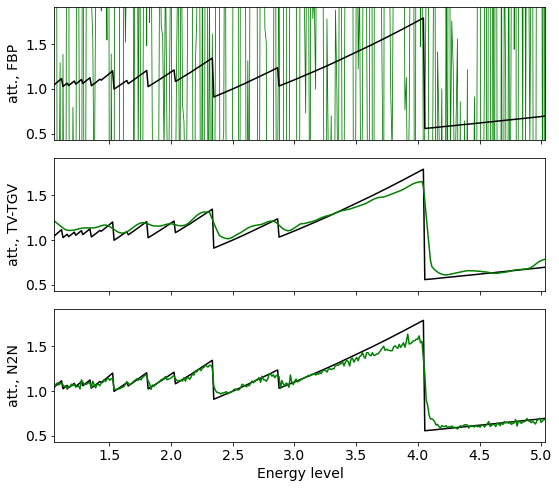

In [74]:
plt.rcParams.update({'font.size': 14})

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(8, 7), sharex=True)


ax1.plot(angstrom_bins_center, raw[0], lw=0.8, label='Raw FBP', c='g')
ax1.plot(angstrom_bins_center, th[0], c='k', label='Theoretical')
ax1.set_ylim(th[0].min()-0.1*(th[0].max() - th[0].min()), th[0].max()+0.1*(th[0].max() - th[0].min()))
ax1.set_xlim(angstrom_bins_center.min(), angstrom_bins_center.max())
ax1.set_ylabel('att., FBP')

ax2.plot(angstrom_bins_center, th[0], c='k', label='Theoretical')
ax2.plot(angstrom_bins_center, tv[0], c='g')
ax2.set_ylim(th[0].min()-0.1*(th[0].max() - th[0].min()), th[0].max()+0.1*(th[0].max() - th[0].min()))
ax2.set_xlim(angstrom_bins_center.min(), angstrom_bins_center.max())
ax2.set_ylabel('att., TV-TGV')

ax3.plot(angstrom_bins_center, th[0], c='k', label='Theoretical')
ax3.plot(angstrom_bins_center, nns[0], c='g')
ax3.set_ylim(th[0].min()-0.1*(th[0].max() - th[0].min()), th[0].max()+0.1*(th[0].max() - th[0].min()))
ax3.set_xlim(angstrom_bins_center.min(), angstrom_bins_center.max())
ax3.set_ylabel('att., N2N')

ax3.set_xlabel('Energy level')

plt.tight_layout()
plt.show()

In [86]:
import pandas as pd
import seaborn as sns

<AxesSubplot:xlabel='material', ylabel='ssim'>

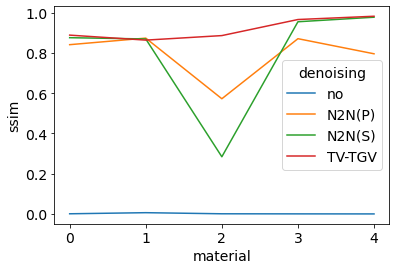

In [23]:
sns.lineplot(data=pd.DataFrame(similarities), x='material', y='ssim', hue='denoising')

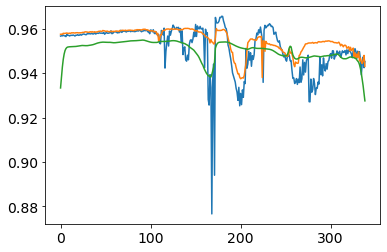

In [27]:
# plt.plot(all_ssims_no, label='no')
plt.plot(all_ssims_slice, label='N2N(S)')
plt.plot(all_ssims_reco, label='N2N(P)')
plt.plot(all_ssims_tv, label='TV-TGV')

In [43]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [73]:
angstrom_bins_center[50]

1.6320784

/tmp/ipykernel_503385/3754046963.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


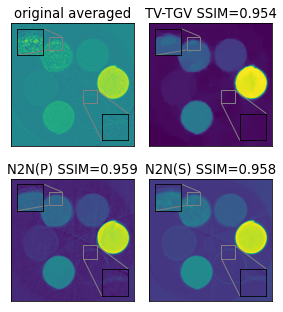

In [72]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(4, 4.5))


def plot_one_slice(cax, cimg):
    cax.imshow(cimg, origin="upper", extent=(0, cimg.shape[0], cimg.shape[1], 0))
    cax.set_xticks([])
    cax.set_yticks([])
    axins = zoomed_inset_axes(cax, 2, loc=2)
    
    callout_size=50
    
    axins.imshow(cimg, origin="upper", extent=(0, cimg.shape[0], cimg.shape[1], 0), interpolation="nearest")
    axins.set_xticks([])
    axins.set_yticks([])
    xl, yl = 140, 50
    axins.set_xlim(xl, xl+50)
    axins.set_ylim(yl+50, yl)
    patch, pp1, pp2 = mark_inset(cax, axins, loc1=3, loc2=3, fc="none", ec="0.5")
    pp1.loc1 = 3
    pp1.loc2 = 2
    pp2.loc1 = 1
    pp2.loc2 = 4
    
    axins = zoomed_inset_axes(cax, 2, loc=4)
    axins.imshow(cimg, origin="upper", extent=(0, cimg.shape[0], cimg.shape[1], 0))
    axins.set_xticks([])
    axins.set_yticks([])
    xl, yl = 270, 250
    axins.set_xlim(xl, xl+50)
    axins.set_ylim(yl+50, yl)
    patch, pp1, pp2 = mark_inset(cax, axins, loc1=2, loc2=1, fc="none", ec="0.5")
    pp1.loc1 = 3
    pp1.loc2 = 2
    pp2.loc1 = 1
    pp2.loc2 = 4

    
plot_one_slice(axes[0][0], reco_before.mean(0))
axes[0][0].set_title('original averaged')
plot_one_slice(axes[0][1], tvtgvd[50])
axes[0][1].set_title(f'TV-TGV SSIM={ssim(tvtgvd[50], reco_before.mean(0)):.3f}')
plot_one_slice(axes[1][0], reco_after[50])
axes[1][0].set_title(f'N2N(P) SSIM={ssim(reco_after[50], reco_before.mean(0)):.3f}')
plot_one_slice(axes[1][1], after_slice[50])
axes[1][1].set_title(f'N2N(S) SSIM={ssim(after_slice[50], reco_before.mean(0)):.3f}')

plt.tight_layout()
plt.savefig('figures/neutron_slices.pdf')
plt.show()

/tmp/ipykernel_1373694/2072630247.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


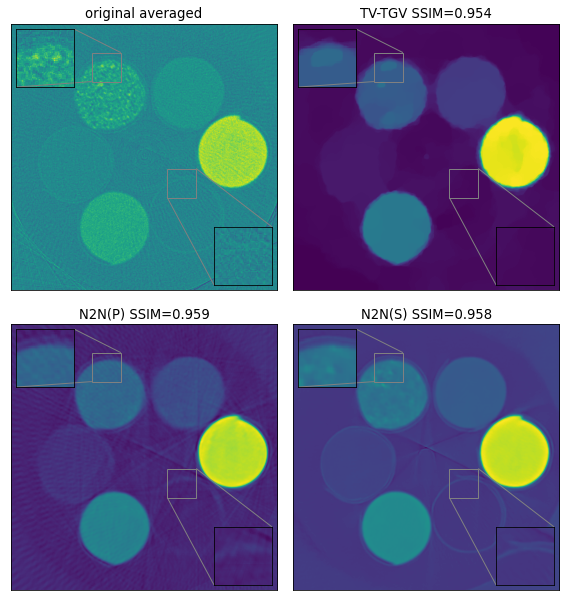

In [51]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 8.5))


def plot_one_slice(cax, cimg):
    cax.imshow(cimg, origin="upper", extent=(0, cimg.shape[0], cimg.shape[1], 0))
    cax.set_xticks([])
    cax.set_yticks([])
    axins = zoomed_inset_axes(cax, 2, loc=2)
    
    callout_size=50
    
    axins.imshow(cimg, origin="upper", extent=(0, cimg.shape[0], cimg.shape[1], 0), interpolation="nearest")
    axins.set_xticks([])
    axins.set_yticks([])
    xl, yl = 140, 50
    axins.set_xlim(xl, xl+50)
    axins.set_ylim(yl+50, yl)
    patch, pp1, pp2 = mark_inset(cax, axins, loc1=3, loc2=3, fc="none", ec="0.5")
    pp1.loc1 = 3
    pp1.loc2 = 2
    pp2.loc1 = 1
    pp2.loc2 = 4
    
    axins = zoomed_inset_axes(cax, 2, loc=4)
    axins.imshow(cimg, origin="upper", extent=(0, cimg.shape[0], cimg.shape[1], 0))
    axins.set_xticks([])
    axins.set_yticks([])
    xl, yl = 270, 250
    axins.set_xlim(xl, xl+50)
    axins.set_ylim(yl+50, yl)
    patch, pp1, pp2 = mark_inset(cax, axins, loc1=2, loc2=1, fc="none", ec="0.5")
    pp1.loc1 = 3
    pp1.loc2 = 2
    pp2.loc1 = 1
    pp2.loc2 = 4

    
plot_one_slice(axes[0][0], reco_before.mean(0))
axes[0][0].set_title('original averaged')
plot_one_slice(axes[0][1], tvtgvd[50])
axes[0][1].set_title(f'TV-TGV SSIM={ssim(tvtgvd[50], reco_before.mean(0)):.3f}')
plot_one_slice(axes[1][0], reco_after[50])
axes[1][0].set_title(f'N2N(P) SSIM={ssim(reco_after[50], reco_before.mean(0)):.3f}')
plot_one_slice(axes[1][1], after_slice[50])
axes[1][1].set_title(f'N2N(S) SSIM={ssim(after_slice[50], reco_before.mean(0)):.3f}')

plt.tight_layout()
plt.savefig('figures/neutron_slices_big.pdf')
plt.show()

In [81]:
reco_before.mean(0).shape

(460, 460)

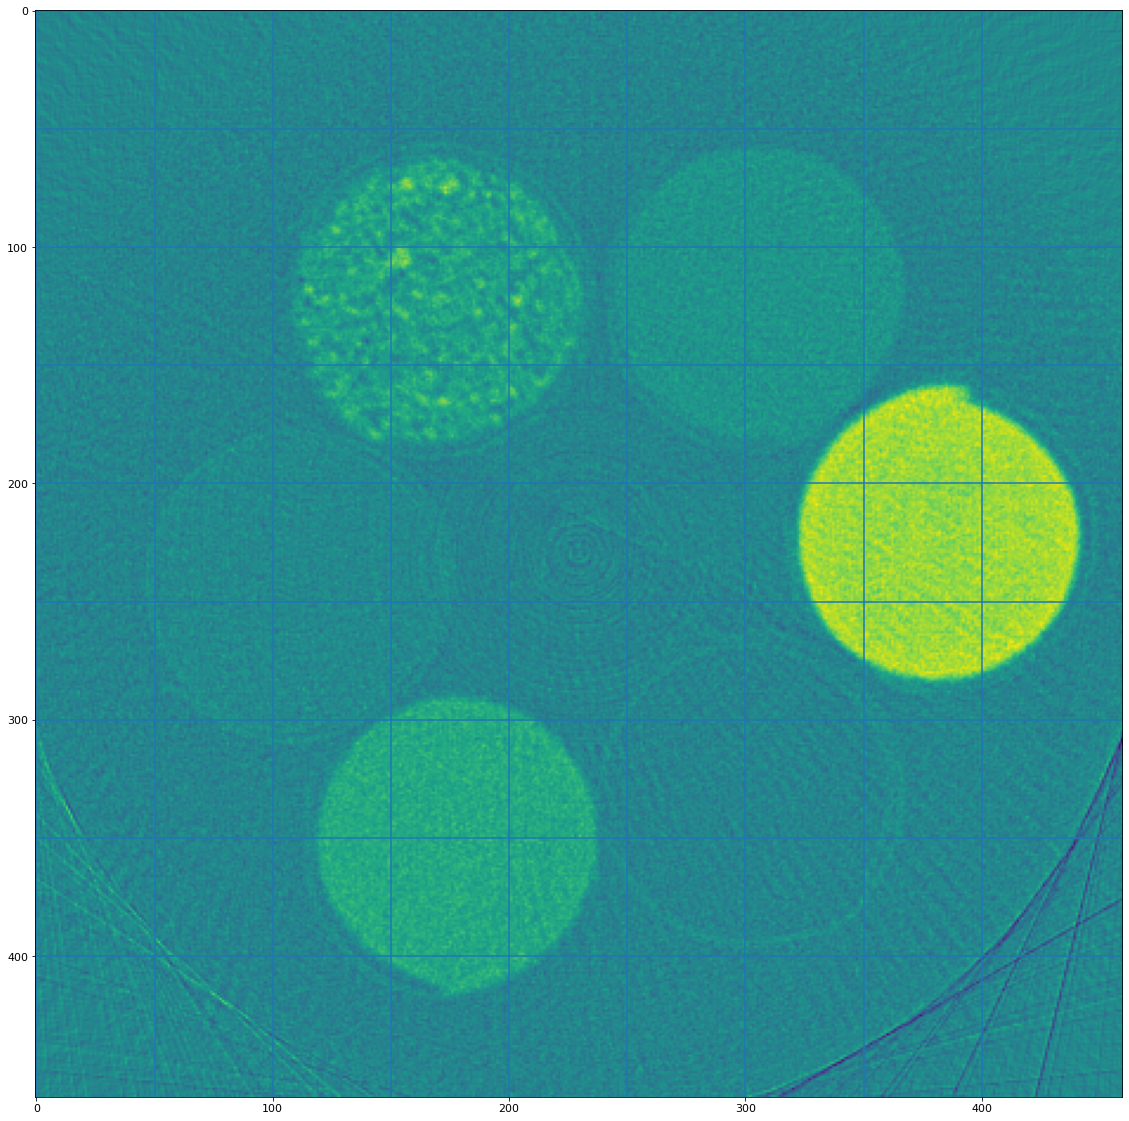

In [82]:
plt.figure(figsize=(20, 20))
plt.imshow(reco_before.mean(0))
for i in range(0, 450, 50):
    plt.axvline(i)
    plt.axhline(i)

In [99]:
starts = [[(50, 100), (50, 230), (150, 310)], [(260, 230), (280, 110), (170, 40)]]

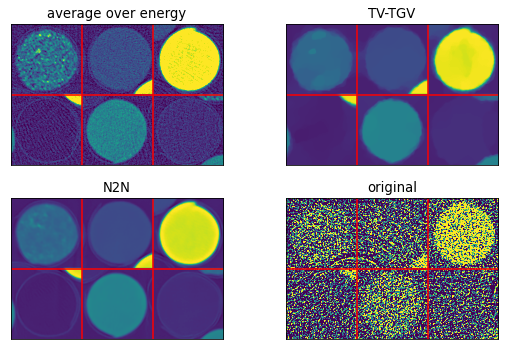

In [101]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 5))


sott = 140
def plot_one_slice(cax, cimg):
    new_img = np.zeros((sott*2, sott*3))
    for i in range(2):
        for j in range(3):
            new_img[i*sott:(i+1)*sott, j*sott:(j+1)*sott] = cimg[starts[i][j][0]:starts[i][j][0]+sott,starts[i][j][1]:starts[i][j][1]+sott]
    cax.imshow(new_img, #cimg[50:200, 100:250], 
#                origin="upper", extent=(0, cimg.shape[0], cimg.shape[1], 0), 
               vmax=0.1, vmin=-0.01)
    cax.axvline(sott, c='r')
    cax.axvline(sott*2, c='r')
    cax.axhline(sott, c='r')
    cax.set_xticks([])
    cax.set_yticks([])
#     axins = zoomed_inset_axes(cax, 2, loc=2)
    
#     callout_size=50
    
#     axins.imshow(cimg, origin="upper", extent=(0, cimg.shape[0], cimg.shape[1], 0), vmax=0.1, vmin=-0.01, interpolation="nearest")
#     axins.set_xticks([])
#     axins.set_yticks([])
#     xl, yl = 140, 50
#     axins.set_xlim(xl, xl+50)
#     axins.set_ylim(yl+50, yl)
#     patch, pp1, pp2 = mark_inset(cax, axins, loc1=3, loc2=3, fc="none", ec="0.5")
#     pp1.loc1 = 3
#     pp1.loc2 = 2
#     pp2.loc1 = 1
#     pp2.loc2 = 4
    
#     axins = zoomed_inset_axes(cax, 2, loc=4)
#     axins.imshow(cimg, origin="upper", extent=(0, cimg.shape[0], cimg.shape[1], 0), vmax=0.1, vmin=-0.01)
#     axins.set_xticks([])
#     axins.set_yticks([])
#     xl, yl = 270, 250
#     axins.set_xlim(xl, xl+50)
#     axins.set_ylim(yl+50, yl)
#     patch, pp1, pp2 = mark_inset(cax, axins, loc1=2, loc2=1, fc="none", ec="0.5")
#     pp1.loc1 = 3
#     pp1.loc2 = 2
#     pp2.loc1 = 1
#     pp2.loc2 = 4

    
plot_one_slice(axes[0][0], reco_before.mean(0))
axes[0][0].set_title('average over energy')
plot_one_slice(axes[0][1], tvtgvd[50])
axes[0][1].set_title(f'TV-TGV')
plot_one_slice(axes[1][0], after_slice[50])
axes[1][0].set_title(f'N2N')
plot_one_slice(axes[1][1], reco_before[50])
axes[1][1].set_title(f'original')

plt.tight_layout()
plt.show()

(array([ 54981., 109359.,  13555.,  11355.,  10874.,    197.,    203.,
           242.,   6407.,   4427.]),
 array([-1.17073413e-02,  7.60452822e-05,  1.18594319e-02,  2.36428194e-02,
         3.54262069e-02,  4.72095907e-02,  5.89929782e-02,  7.07763657e-02,
         8.25597495e-02,  9.43431407e-02,  1.06126525e-01], dtype=float32),
 <BarContainer object of 10 artists>)

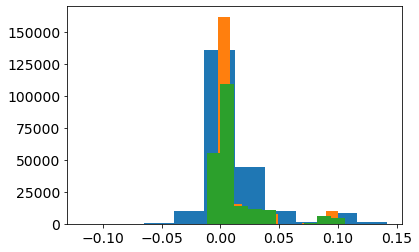

In [66]:
plt.hist(reco_before.mean(0).flatten())
plt.hist(tvtgvd[50].flatten())
plt.hist(reco_after[50].flatten())
# plt.hist(reco_before[50].flatten())

# Calculating similarities over all channels

In [53]:
spatial_similarities = []
similarities = []

In [56]:
after_slice = tifffile.imread('/mnt/HD-LSDF/sd18a004/for_yaroslav/neutron_data/n2n_results/processed_after_reconstruction/127.tif')[:, 12:-12, 12:-12]

In [57]:
sino_after = []
for i in tqdm(range(120)):
    img = tifffile.memmap(f'/mnt/HD-LSDF/sd18a004/for_yaroslav/neutron_data/n2n_results/processed_first/{i}.tif')
    sino_after.append(img[:, slice_number])
sino_after = np.stack(sino_after, axis=1)
reco_after = reconstruct_one_slice(sino_after, n_channels=339)[:, 12:-12, 12:-12]

  0%|          | 0/120 [00:00<?, ?it/s]

reconstructing channels:   0%|          | 0/339 [00:00<?, ?it/s]

In [58]:
slice_number = 127

sino_before = []
for i in tqdm(range(120)):
    sino_before.append(np.load(f'/mnt/HD-LSDF/sd18a004/for_yaroslav/neutron_data/preprocessed_projections/projections_339/proj_{i}.npy', 
                               mmap_mode='r')[:, slice_number])
sino_before = np.stack(sino_before, axis=1)

reco_before = reconstruct_one_slice(sino_before, n_channels=339)[:, 12:-12, 12:-12]

  0%|          | 0/120 [00:00<?, ?it/s]

reconstructing channels:   0%|          | 0/339 [00:00<?, ?it/s]

In [59]:
th = prepare_spectrum_points()
raw = prepare_spectrum_points(reconstructed_slice=reco_before)
nnp = prepare_spectrum_points(reconstructed_slice=reco_after)
nns = prepare_spectrum_points(reconstructed_slice=after_slice)

In [60]:
baseline = reco_before.mean(0)
all_ssims_reco = [ssim(reco_after[i], baseline) for i in tqdm(range(len(reco_after)))]
all_ssims_slice = [ssim(after_slice[i], baseline) for i in tqdm(range(len(after_slice)))]
all_ssims_no = [ssim(reco_before[i], baseline) for i in tqdm(range(len(reco_before)))]
all_ssims_tv = [ssim(tvtgvd[i], baseline) for i in tqdm(range(len(tvtgvd)))]

  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/339 [00:00<?, ?it/s]

In [61]:
for i in range(5):
    cth = th[i].squeeze()
    similarities.append({'denoising': 'no', 'material': i, 'ssim': ssim(cth, raw[i]), 'channels': 339})
    similarities.append({'denoising': 'N2N(P)', 'material': i, 'ssim': ssim(cth, nnp[i]), 'channels': 339})
    similarities.append({'denoising': 'N2N(S)', 'material': i, 'ssim': ssim(cth, nns[i]), 'channels': 339})
    similarities.append({'denoising': 'TV-TGV', 'material': i, 'ssim': ssim(cth, tv[i]), 'channels': 339})

In [62]:
spatial_similarities.append({'denoising': 'no', 'material': i, 'ssim': np.median(all_ssims_no), 'channels': 339})
spatial_similarities.append({'denoising': 'N2N(P)', 'material': i, 'ssim': np.median(all_ssims_reco), 'channels': 339})
spatial_similarities.append({'denoising': 'N2N(S)', 'material': i, 'ssim': np.median(all_ssims_slice), 'channels': 339})
spatial_similarities.append({'denoising': 'TV-TGV', 'material': i, 'ssim': np.median(all_ssims_tv), 'channels': 339})

## Add 681

In [63]:
after_slice = tifffile.imread('/mnt/HD-LSDF/sd18a004/for_yaroslav/neutron_data/n2n_results/reconstructions_681_processed/127.tif')[:, 12:-12, 12:-12]
after_slice = np.concatenate((after_slice[[0]], after_slice, after_slice[[-1]]))

In [64]:
slice_number = 127

sino_before = []
for i in tqdm(range(120)):
    sino_before.append(np.load(f'/mnt/HD-LSDF/sd18a004/for_yaroslav/neutron_data/preprocessed_projections/projections_681/proj_{i}.npy', 
                               mmap_mode='r')[:, slice_number])
sino_before = np.stack(sino_before, axis=1)
reco_before = reconstruct_one_slice(sino_before, n_channels=681)[:, 12:-12, 12:-12]

  0%|          | 0/120 [00:00<?, ?it/s]

reconstructing channels:   0%|          | 0/681 [00:00<?, ?it/s]

In [65]:
sino_after = []
for i in tqdm(range(120)):
    img = tifffile.memmap(f'/mnt/HD-LSDF/sd18a004/for_yaroslav/neutron_data/n2n_results/projections_681_processed/proj_{i}.npy')
    sino_after.append(img[:, slice_number])
sino_after = np.stack(sino_after, axis=1)
reco_after = reconstruct_one_slice(np.concatenate([sino_after[[0]], sino_after, sino_after[[-1]]]), n_channels=681)[:, 12:-12, 12:-12]

  0%|          | 0/120 [00:00<?, ?it/s]

reconstructing channels:   0%|          | 0/681 [00:00<?, ?it/s]

In [66]:
th = prepare_spectrum_points(binning=[8, 4, 4, 2])
raw = prepare_spectrum_points(reconstructed_slice=reco_before, binning=[8, 4, 4, 2])
nnp = prepare_spectrum_points(reconstructed_slice=reco_after, binning=[8, 4, 4, 2])
nns = prepare_spectrum_points(reconstructed_slice=after_slice, binning=[8, 4, 4, 2])

In [67]:
for i in range(5):
    cth = th[i].squeeze()
    similarities.append({'denoising': 'no', 'material': i, 'ssim': ssim(cth, raw[i]), 'channels': 681})
    similarities.append({'denoising': 'N2N(P)', 'material': i, 'ssim': ssim(cth, nnp[i]), 'channels': 681})
    similarities.append({'denoising': 'N2N(S)', 'material': i, 'ssim': ssim(cth, nns[i]), 'channels': 681})

In [68]:
baseline = reco_before.mean(0)
all_ssims_reco = [ssim(reco_after[i], baseline) for i in tqdm(range(len(reco_after)))]
all_ssims_slice = [ssim(after_slice[i], baseline) for i in tqdm(range(len(after_slice)))]
all_ssims_no = [ssim(reco_before[i], baseline) for i in tqdm(range(len(reco_before)))]

  0%|          | 0/681 [00:00<?, ?it/s]

  0%|          | 0/681 [00:00<?, ?it/s]

  0%|          | 0/681 [00:00<?, ?it/s]

In [69]:
spatial_similarities.append({'denoising': 'no', 'material': i, 'ssim': np.median(all_ssims_no), 'channels': 681})
spatial_similarities.append({'denoising': 'N2N(P)', 'material': i, 'ssim': np.median(all_ssims_reco), 'channels': 681})
spatial_similarities.append({'denoising': 'N2N(S)', 'material': i, 'ssim': np.median(all_ssims_slice), 'channels': 681})

## Add 1366

In [70]:
after_slice = tifffile.imread('/mnt/HD-LSDF/sd18a004/for_yaroslav/neutron_data/n2n_results/reconstructions_1366_processed/127.tif')[:, 12:-12, 12:-12]
after_slice = np.concatenate((after_slice[[0]], after_slice, after_slice[[-1]]))

In [71]:
slice_number = 127

sino_before = []
for i in tqdm(range(120)):
    sino_before.append(np.load(f'/mnt/HD-LSDF/sd18a004/for_yaroslav/neutron_data/preprocessed_projections/projections_1366/proj_{i}.npy', 
                               mmap_mode='r')[:, slice_number])
sino_before = np.stack(sino_before, axis=1)
reco_before = reconstruct_one_slice(sino_before, n_channels=1366)[:, 12:-12, 12:-12]

  0%|          | 0/120 [00:00<?, ?it/s]

reconstructing channels:   0%|          | 0/1366 [00:00<?, ?it/s]

In [72]:
sino_after = []
for i in tqdm(range(120)):
    img = tifffile.memmap(f'/mnt/HD-LSDF/sd18a004/for_yaroslav/neutron_data/n2n_results/projections_1366_processed/proj_{i}.npy')
    sino_after.append(img[:, slice_number])
sino_after = np.stack(sino_after, axis=1)
reco_after = reconstruct_one_slice(np.concatenate([sino_after[[0]], sino_after, sino_after[[-1]]]), n_channels=1366)[:, 12:-12, 12:-12]

  0%|          | 0/120 [00:00<?, ?it/s]

reconstructing channels:   0%|          | 0/1366 [00:00<?, ?it/s]

In [73]:
th = prepare_spectrum_points(binning=[4, 2, 2, 1])
raw = prepare_spectrum_points(reconstructed_slice=reco_before, binning=[4, 2, 2, 1])
nnp = prepare_spectrum_points(reconstructed_slice=reco_after, binning=[4, 2, 2, 1])
nns = prepare_spectrum_points(reconstructed_slice=after_slice, binning=[4, 2, 2, 1])

In [74]:
for i in range(5):
    cth = th[i].squeeze()
    similarities.append({'denoising': 'no', 'material': i, 'ssim': ssim(cth, raw[i]), 'channels': 1366})
    similarities.append({'denoising': 'N2N(P)', 'material': i, 'ssim': ssim(cth, nnp[i]), 'channels': 1366})
    similarities.append({'denoising': 'N2N(S)', 'material': i, 'ssim': ssim(cth, nns[i]), 'channels': 1366})

In [75]:
baseline = reco_before.mean(0)
all_ssims_reco = [ssim(reco_after[i], baseline) for i in tqdm(range(len(reco_after)))]
all_ssims_slice = [ssim(after_slice[i], baseline) for i in tqdm(range(len(after_slice)))]
all_ssims_no = [ssim(reco_before[i], baseline) for i in tqdm(range(len(reco_before)))]

  0%|          | 0/1366 [00:00<?, ?it/s]

  0%|          | 0/1366 [00:00<?, ?it/s]

  0%|          | 0/1366 [00:00<?, ?it/s]

In [76]:
spatial_similarities.append({'denoising': 'no', 'material': i, 'ssim': np.median(all_ssims_no), 'channels': 1366})
spatial_similarities.append({'denoising': 'N2N(P)', 'material': i, 'ssim': np.median(all_ssims_reco), 'channels': 1366})
spatial_similarities.append({'denoising': 'N2N(S)', 'material': i, 'ssim': np.median(all_ssims_slice), 'channels': 1366})

## Add 2840

In [77]:
after_slice = tifffile.imread('/mnt/HD-LSDF/sd18a004/for_yaroslav/neutron_data/n2n_results/reconstructions_2840_processed/127.tif')[:, 12:-12, 12:-12]
after_slice = np.concatenate((after_slice[[0]], after_slice, after_slice[[-1]]))

In [78]:
slice_number = 127

sino_before = []
for i in tqdm(range(120)):
    sino_before.append(np.load(f'/mnt/HD-LSDF/sd18a004/for_yaroslav/neutron_data/preprocessed_projections/projections_2840/proj_{i}.npy', 
                               mmap_mode='r')[:, slice_number])
sino_before = np.stack(sino_before, axis=1)
reco_before = reconstruct_one_slice(sino_before, n_channels=2840)[:, 12:-12, 12:-12]

  0%|          | 0/120 [00:00<?, ?it/s]

reconstructing channels:   0%|          | 0/2840 [00:00<?, ?it/s]

In [79]:
sino_after = []
for i in tqdm(range(120)):
    img = tifffile.memmap(f'/mnt/HD-LSDF/sd18a004/for_yaroslav/neutron_data/n2n_results/projections_2840_processed/proj_{i}.npy.tif')
    sino_after.append(img[:, slice_number])
sino_after = np.stack(sino_after, axis=1)
reco_after = reconstruct_one_slice(np.concatenate([sino_after[[0]], sino_after, sino_after[[-1]]]), n_channels=2840)[:, 12:-12, 12:-12]

  0%|          | 0/120 [00:00<?, ?it/s]

reconstructing channels:   0%|          | 0/2840 [00:00<?, ?it/s]

In [80]:
th = prepare_spectrum_points(binning=[1, 1, 1, 1])
raw = prepare_spectrum_points(reconstructed_slice=reco_before, binning=[1, 1, 1, 1])
nnp = prepare_spectrum_points(reconstructed_slice=reco_after, binning=[1, 1, 1, 1])
nns = prepare_spectrum_points(reconstructed_slice=after_slice, binning=[1, 1, 1, 1])

In [81]:
for i in range(5):
    cth = th[i].squeeze()
    similarities.append({'denoising': 'no', 'material': i, 'ssim': ssim(cth, raw[i]), 'channels': 2840})
    similarities.append({'denoising': 'N2N(P)', 'material': i, 'ssim': ssim(cth, nnp[i]), 'channels': 2840})
    similarities.append({'denoising': 'N2N(S)', 'material': i, 'ssim': ssim(cth, nns[i]), 'channels': 2840})

In [82]:
baseline = reco_before.mean(0)
all_ssims_reco = [ssim(reco_after[i], baseline) for i in tqdm(range(len(reco_after)))]
all_ssims_slice = [ssim(after_slice[i], baseline) for i in tqdm(range(len(after_slice)))]
all_ssims_no = [ssim(reco_before[i], baseline) for i in tqdm(range(len(reco_before)))]

  0%|          | 0/2840 [00:00<?, ?it/s]

  0%|          | 0/2840 [00:00<?, ?it/s]

  0%|          | 0/2840 [00:00<?, ?it/s]

In [83]:
spatial_similarities.append({'denoising': 'no', 'material': i, 'ssim': np.median(all_ssims_no), 'channels': 2840})
spatial_similarities.append({'denoising': 'N2N(P)', 'material': i, 'ssim': np.median(all_ssims_reco), 'channels': 2840})
spatial_similarities.append({'denoising': 'N2N(S)', 'material': i, 'ssim': np.median(all_ssims_slice), 'channels': 2840})

## Prepare the plot and the table

In [88]:
similarities_df = pd.DataFrame(similarities)

In [89]:
similarities_df = pd.merge(left = similarities_df, 
         right=similarities_df[similarities_df.denoising == 'no'].groupby('channels').mean().ssim,
         left_on='channels', right_index=True)

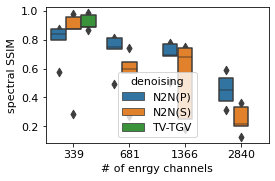

In [166]:
plt.figure(figsize=(4, 2.5))
sns.boxenplot(data=similarities_df[similarities_df.denoising!='no'], x='channels', y='ssim_x', 
             hue='denoising')
plt.xlabel('# of enrgy channels')
plt.ylabel('spectral SSIM')
plt.savefig('figures/neutron_spectral_ssim.pdf')
# plt.gca().set_xticklabels([f'{2840/339:.2f}', f'{2840/681:.2f}', f'{2840/1366:.2f}', 1])
# plt.gca().set_xticklabels(['[16, 8, 8, 4]', '[8, 4, 4, 2]', '[4, 2, 2, 1]', '[1, 1, 1, 1]'])
# plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.3f}'))

/home/ws/tb0536/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.17254901960784313, 0.6274509803921569, 0.17254901960784313)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,


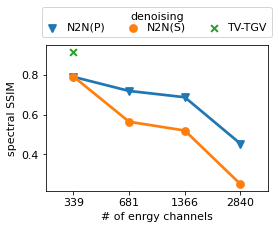

In [90]:
plt.figure(figsize=(4, 3.5))
sns.pointplot(data=similarities_df[similarities_df.denoising!='no'], x='channels', y='ssim_x', 
             hue='denoising', markers=['v', 'o', 'x'], ci=0)
# sns.scatterplot(data=similarities_df[similarities_df.denoising!='no'], x='channels', y='ssim_x', 
#              hue='denoising')
plt.xlabel('# of enrgy channels')
plt.ylabel('spectral SSIM')
plt.legend(loc=9, ncol=3, bbox_to_anchor=(0.5, 1.3), handlelength=1, labelspacing=0.1, title='denoising')
plt.tight_layout()
plt.savefig('figures/neutron_spectral_ssim.pdf')
# plt.gca().set_xticklabels([f'{2840/339:.2f}', f'{2840/681:.2f}', f'{2840/1366:.2f}', 1])
# plt.gca().set_xticklabels(['[16, 8, 8, 4]', '[8, 4, 4, 2]', '[4, 2, 2, 1]', '[1, 1, 1, 1]'])
# plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.3f}'))

In [139]:
import matplotlib.patches as patches

/home/ws/tb0536/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.17254901960784313, 0.6274509803921569, 0.17254901960784313)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,


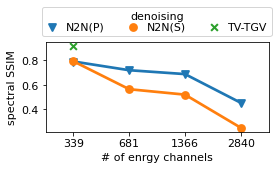

In [170]:
plt.figure(figsize=(4, 2.5))
sns.pointplot(data=similarities_df[similarities_df.denoising!='no'], x='channels', y='ssim_x', 
             hue='denoising', markers=['v', 'o', 'x'], ci=0)
# sns.scatterplot(data=similarities_df[similarities_df.denoising!='no'], x='channels', y='ssim_x', 
#              hue='denoising')
plt.xlabel('# of enrgy channels')
plt.ylabel('spectral SSIM')
plt.gca().legend(loc='lower left', ncol=3, bbox_to_anchor=(-0.04, 1, 0.1, 0.1), handlelength=1, labelspacing=0.1, title='denoising')
plt.tight_layout()
plt.savefig('figures/neutron_spectral_ssim_small.pdf')
# plt.gca().set_xticklabels([f'{2840/339:.2f}', f'{2840/681:.2f}', f'{2840/1366:.2f}', 1])
# plt.gca().set_xticklabels(['[16, 8, 8, 4]', '[8, 4, 4, 2]', '[4, 2, 2, 1]', '[1, 1, 1, 1]'])
# plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.3f}'))

In [165]:
spatial_similarities_df = pd.DataFrame(spatial_similarities)

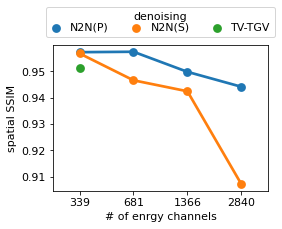

In [225]:
plt.figure(figsize=(4, 3.5))
sns.pointplot(data=spatial_similarities_df[spatial_similarities_df.denoising!='no'], x='channels', y='ssim', 
             hue='denoising')
# sns.scatterplot(data=spatial_similarities_df[spatial_similarities_df.denoising!='no'], x='channels', y='ssim', 
             # hue='denoising', legend=False)
plt.xlabel('# of enrgy channels')
plt.ylabel('spatial SSIM')
plt.legend(loc=9, ncol=3, bbox_to_anchor=(0.5, 1.3), handlelength=1, labelspacing=0.1, title='denoising')
plt.tight_layout()
plt.savefig('figures/neutron_spatial_ssim.pdf')
# plt.gca().set_xticklabels([f'{2840/339:.2f}', f'{2840/681:.2f}', f'{2840/1366:.2f}', 1])
# plt.gca().set_xticklabels(['[16, 8, 8, 4]', '[8, 4, 4, 2]', '[4, 2, 2, 1]', '[1, 1, 1, 1]'])
# # plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.3f}'))

/home/ws/tb0536/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.17254901960784313, 0.6274509803921569, 0.17254901960784313)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,


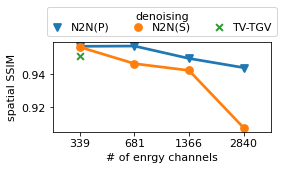

In [172]:
plt.figure(figsize=(4, 2.5))
sns.pointplot(data=spatial_similarities_df[spatial_similarities_df.denoising!='no'], x='channels', y='ssim', 
             hue='denoising', markers=['v', 'o', 'x'])
# sns.scatterplot(data=spatial_similarities_df[spatial_similarities_df.denoising!='no'], x='channels', y='ssim', 
             # hue='denoising', legend=False)
plt.xlabel('# of enrgy channels')
plt.ylabel('spatial SSIM')
plt.gca().legend(loc='lower left', ncol=3, bbox_to_anchor=(-0.05, 1, 0.1, 0.1), handlelength=1, labelspacing=0.1, title='denoising')
plt.tight_layout()
plt.savefig('figures/neutron_spatial_ssim_small.pdf')
# plt.gca().set_xticklabels([f'{2840/339:.2f}', f'{2840/681:.2f}', f'{2840/1366:.2f}', 1])
# plt.gca().set_xticklabels(['[16, 8, 8, 4]', '[8, 4, 4, 2]', '[4, 2, 2, 1]', '[1, 1, 1, 1]'])
# # plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.3f}'))